# XGBOOST BASELINE for Semeval - Laptops 2014 joint

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix, classification_report

## Preprocessing

Function to add [CLS] and [SEP] as separator tokens at beginning/ending of each text item and to format aspect and polarity columns as lists:

In [0]:
def changeFormat(dataset):

  df = pd.DataFrame(dataset)
  text = df['text']
  joint = df['joint']
  df2 = pd.DataFrame({'text': '[CLS] ' + text + ' [SEP]',
                    'joint': joint})
  
  df2['joint'] = [x.split(',') for x in df2['joint']]
  
  return df2

Read csv files from Google Drive (directly from shared group drive "NLP Lab"):

In [0]:
L14_train = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/Data_Final/Train data/semevalLaptops_14_red_joint_train.csv")

In [5]:
L14_train = changeFormat(L14_train)
L14_train.head()

,text,joint
0,"[CLS] But the quality, in general was less tha...",[quality/negative]
1,"[CLS] The 2 GB of RAM is plenty, able to run W...","[programs/positive, Windows 7/positive]"
2,"[CLS] however, I may have inadvertently thrown...",[batteries/neutral]
3,[CLS] It takes me approximately 3 tries to get...,[browser/neutral]
4,"[CLS] The Macbook is also made better, my comp...",[runs/positive]


In [0]:
L14_test = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/Data_Final/Test data/semevalLaptops_14_red_joint_test.csv")

In [7]:
L14_test = changeFormat(L14_test)
L14_test.head()

,text,joint
0,[CLS] The touch pad is among the best. [SEP],[touch pad/positive]
1,[CLS] Its a good laptop for its value. [SEP],[value/positive]
2,[CLS] It's software and speed enable it to do ...,"[software/positive, speed/positive]"
3,"[CLS] The laptop is relatively simple to use, ...",[use/positive]
4,[CLS] This computer doesn't do that well with ...,[games/negative]


Shape of the train and test data:

In [8]:
L14_train.shape

(772, 2)

In [9]:
L14_test.shape

(194, 2)

##**BERT embeddings**

Preprocessing to import BERT embeddings file of group in Colab

In [10]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 655kB 51.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built regex


In [11]:
!pwd

/content


In [12]:
%cd "/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline"

/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline


In [13]:
!ls

embeddings.py  Laptop  __pycache__  Restaurant


In [0]:
from embeddings import Embeddings

In [15]:
embed = Embeddings()

100%|██████████| 407873900/407873900 [00:06<00:00, 64204222.66B/s]


Get BERT embeddings for train and test data:

In [0]:
L14_train_embeddings = embed.get_embeddings(L14_train.text, all=False)
L14_test_embeddings = embed.get_embeddings(L14_test.text, all=False)

Plausibility check

In [17]:
# number of vectors 
len(L14_train_embeddings[0])

18

In [18]:
#string is counted letter per letter
len(L14_train['text'][0])

84

In [19]:
# original text
L14_train['text'][0]

'[CLS] But the quality, in general was less than the worth of the cheap laptop. [SEP]'

In [20]:
# vectors
L14_train_embeddings[0]

tensor([[-0.5375, -0.1199, -0.2145,  ..., -0.2659,  0.2195,  0.3163],
        [-0.4366, -0.0047, -0.1131,  ..., -0.2846,  0.4466,  0.2884],
        [-0.7832, -0.0535, -0.3677,  ...,  0.0823,  0.5573, -0.0568],
        ...,
        [ 0.0591,  0.1924,  0.1599,  ...,  0.1369,  0.1847, -0.5659],
        [ 0.4153,  0.0822, -0.3362,  ...,  0.2569, -0.2108, -0.4409],
        [ 0.1337,  0.1386,  0.1055,  ...,  0.3647, -0.2866, -0.2439]])

In [21]:
len(L14_test_embeddings[0])

10

In [22]:
L14_test['text'][0]

'[CLS] The touch pad is among the best. [SEP]'

In [0]:
L14_train['embeddings'] = [e[0].numpy() for e in L14_train_embeddings]
L14_test['embeddings'] = [e[0].numpy() for e in L14_test_embeddings]

##**XGBOOST Baseline Model for Joint aspect and polarity**

In [25]:
L14_joint = MultiLabelBinarizer()
L14_joint.fit(L14_train.joint)
L14_joint.classes_

array(['BIOS/negative', 'Bluetooth/negative', 'Bluetooth/neutral',
       'Customer Service/negative', 'Customer Service/positive',
       'DVD burner/negative', 'Features/neutral', 'GarageBand/neutral',
       'GarageBand/positive', 'Garageband/neutral', 'HD/negative',
       'HD/positive', 'Keyboard/negative', 'Keyboard/positive',
       'Keynote/neutral', 'MS Office/neutral', 'Mac OS/positive',
       'OS X/negative', 'OS X/neutral', 'OS X/positive', 'OS/neutral',
       'OS/positive', 'Pages/neutral', 'Pages/positive',
       'Photoshop/neutral', 'Photoshop/positive', 'RAM/negative',
       'RAM/neutral', 'RAM/positive', 'Runs/positive', 'Screen/neutral',
       'Screen/positive', 'Touchpad/neutral', 'USB ports/positive',
       'Vista/negative', 'Vista/neutral', 'Windows 7 Starter/negative',
       'Windows 7 Starter/neutral', 'Windows 7 Starter/positive',
       'Windows 7/neutral', 'Windows 7/positive', 'Windows/negative',
       'Windows/neutral', 'Windows/positive', 'Word/nega

In [26]:
y_L14_train_joint = L14_joint.transform(L14_train.joint)
y_L14_test_joint = L14_joint.transform(L14_test.joint)
y_L14_train_joint[3]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['DVD burner/positive', 'Features/negative', 'Garageband/positive', 'MS Office/negative', 'MS Office/positive', 'Runs/negative', 'Touchpad/negative', 'USB ports/negative', 'appearance/negative', 'appearance/positive', 'boot up/neutral', 'carry/negative', 'case/neutral', 'case/positive', 'components/positive', 'cords/positive', 'games/negative', 'graphics card/negative', 'mousepad/positive', 'navigate/negative', 'run/negative', 'specifications/negative', 'touch pad/negative', 'trackpad/negative', 'warrenty/neutral', 'works/negative'] will be ignored
  .format(sorted(unknown, key=str)))


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
L14_xgb_joint = OneVsRestClassifier(XGBClassifier(objective='binary:logistic', n_estimators=500 , max_depth=3,
                                               learning_rate=0.05, n_jobs=24, verbosity=1,
                                               min_child_weight=20, scale_pos_weight=6, base_score=0.2))
L14_xgb_joint.fit(np.array(list(L14_train.embeddings)), y_L14_train_joint)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.2, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=3,
                                            min_child_weight=20, missing=None,
                                            n_estimators=500, n_jobs=24,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=6,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
        

In [29]:
L14_joint_report = classification_report(y_L14_test_joint, L14_xgb_joint.predict(np.array(list(L14_test.embeddings))),
                            target_names=L14_joint.classes_, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


Text(0.5, 1.0, 'Multi-label aspect classification performance')

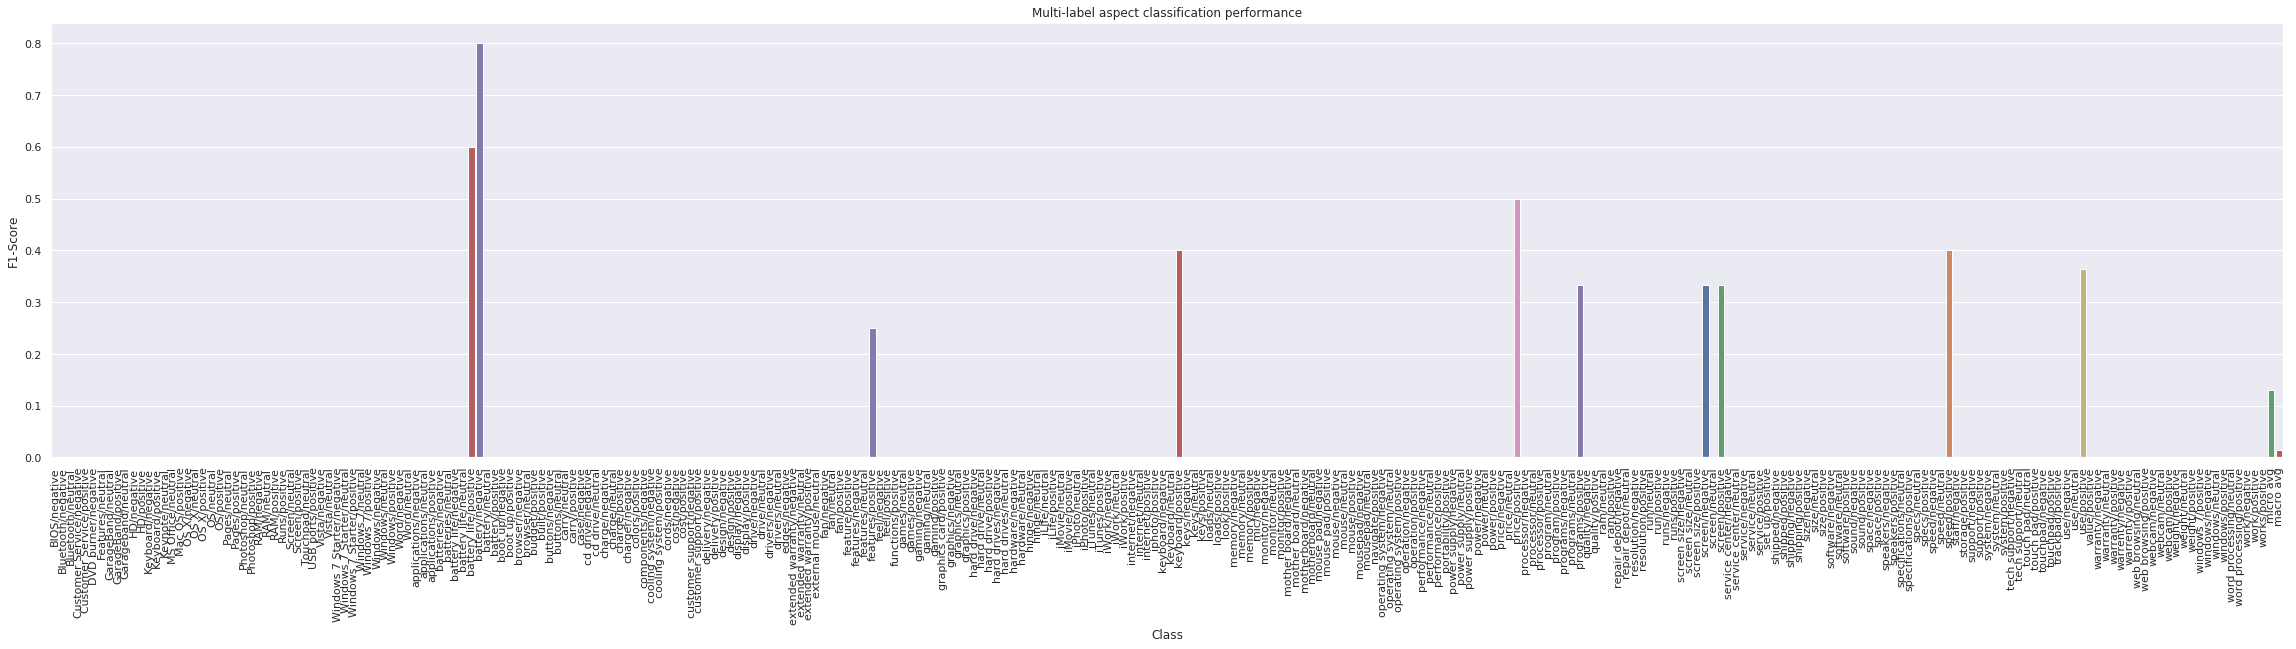

In [33]:
L14_f1s_joint = []
for key in L14_joint_report.keys():
    L14_f1s_joint.append(L14_joint_report.get(key).get('f1-score'))

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(40,8)})
sns.barplot(list(L14_joint_report.keys())[:-2], L14_f1s_joint[:-2], palette='deep')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Multi-label aspect classification performance')

In [31]:
[plt.text(v, i, '{:.2f}'.format(v)) for i, v in enumerate(L14_f1s_joint[:-2])]

[Text(0.0, 0, '0.00'),
 Text(0.0, 1, '0.00'),
 Text(0.0, 2, '0.00'),
 Text(0.0, 3, '0.00'),
 Text(0.0, 4, '0.00'),
 Text(0.0, 5, '0.00'),
 Text(0.0, 6, '0.00'),
 Text(0.0, 7, '0.00'),
 Text(0.0, 8, '0.00'),
 Text(0.0, 9, '0.00'),
 Text(0.0, 10, '0.00'),
 Text(0.0, 11, '0.00'),
 Text(0.0, 12, '0.00'),
 Text(0.0, 13, '0.00'),
 Text(0.0, 14, '0.00'),
 Text(0.0, 15, '0.00'),
 Text(0.0, 16, '0.00'),
 Text(0.0, 17, '0.00'),
 Text(0.0, 18, '0.00'),
 Text(0.0, 19, '0.00'),
 Text(0.0, 20, '0.00'),
 Text(0.0, 21, '0.00'),
 Text(0.0, 22, '0.00'),
 Text(0.0, 23, '0.00'),
 Text(0.0, 24, '0.00'),
 Text(0.0, 25, '0.00'),
 Text(0.0, 26, '0.00'),
 Text(0.0, 27, '0.00'),
 Text(0.0, 28, '0.00'),
 Text(0.0, 29, '0.00'),
 Text(0.0, 30, '0.00'),
 Text(0.0, 31, '0.00'),
 Text(0.0, 32, '0.00'),
 Text(0.0, 33, '0.00'),
 Text(0.0, 34, '0.00'),
 Text(0.0, 35, '0.00'),
 Text(0.0, 36, '0.00'),
 Text(0.0, 37, '0.00'),
 Text(0.0, 38, '0.00'),
 Text(0.0, 39, '0.00'),
 Text(0.0, 40, '0.00'),
 Text(0.0, 41, '0.00'),
 T

ValueError: ignored

<Figure size 1440x576 with 1 Axes>